In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import tqdm

import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats import pearsonr

import oddt
from oddt.scoring.functions.PLECscore import PLECscore
from oddt.scoring.functions import RFScore
from oddt.scoring.functions import NNScore

In [2]:
df = pd.read_csv('./41586_2019_917_MOESM4_ESM.csv').iloc[:-4]
inhibition = df['Inhibition (%) at 10uM'].astype(float).values
smiles = df['SMILES']
zincnames = df['ZINC ID']


In [3]:
mols = []
with Chem.SDMolSupplier('docked.sdf') as sup:
    for m in sup:
        if m is not None:
            mols.append(m)
            
print(len(mols)//9)

548


# Testing Re-scoring algorithms from ODDT on the D4 docking results



In [4]:
# First define a function that takes a scoring method, re-scores the compounds,
# and returns a dataframe of the results:

In [5]:
def re_score(method, mols):
    """
    Method is one of: 
    - PLEClinear_p5_l1_s65536
    - rfscore_v1
    - nnscore
    """
    rescorers = {'PLEClinear_p5_l1_s65536':PLECscore('rf'),
                'rfscore_v1':RFScore.rfscore(),
                'nnscore':NNScore.nnscore()}

    names = []
    re_scores = []


    scorer = rescorers[method]
    scorer.train()
    
    oddt_prot = next(oddt.toolkit.readfile('pdb', './protein_5WIU.pdbqt'))
    oddt_prot.protein=True 
    scorer.set_protein(oddt_prot)


    for m in tqdm.tqdm_notebook(mols, total=len(mols)):
        names.append(m.GetProp('_Name'))
        Chem.MolToMolFile(m, 'temp.sdf')
        oddt_lig = next(oddt.toolkit.readfile('sdf', 'temp.sdf'))
        scored_mol = scorer.predict_ligand(oddt_lig)
        re_scores.append(float(scored_mol.data[method]))
        
    re_scored_df = pd.DataFrame({'names':names, 're_scores':re_scores, 'method':method})
    re_scored_df = re_scored_df.sort_values('re_scores', ascending=False).drop_duplicates('names')
    return re_scored_df

In [6]:
rfscore = re_score('rfscore_v1',mols)

Training RFScore v1 on PDBBind v2016
Test set:	R2_score: 0.5496	Rp: 0.7884	RMSE: 1.4585	SD: 1.3393
Train set:	R2_score: 0.8777	Rp: 0.9517	RMSE: 0.6978	SD: 0.6127
OOB set:	R2_score: 0.5313	Rp: 0.7305	RMSE: 1.3659	SD: 1.3628
/var/folders/jh/02165y2n7kq2y5ychxtzcjm40000gn/T/ipykernel_56567/254625368.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm.tqdm_notebook(mols, total=len(mols)):


  0%|          | 0/4940 [00:00<?, ?it/s]

In [8]:
plecscore = re_score('PLEClinear_p5_l1_s65536',mols)

Loading pretrained PLECscore linear with depths P5 L1 on PDBBind v2016
/var/folders/jh/02165y2n7kq2y5ychxtzcjm40000gn/T/ipykernel_56567/254625368.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm.tqdm_notebook(mols, total=len(mols)):


  0%|          | 0/4940 [00:00<?, ?it/s]

In [9]:
nnscore = re_score('nnscore', mols)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 out of 1000 | elapsed:  1.1min remaining: 10.4min
[Parallel(n_jobs=-1)]: Done 193 out of 1000 | elapsed:  2.1min remaining:  8.7min
[Parallel(n_jobs=-1)]: Done 294 out of 1000 | elapsed:  3.1min remaining:  7.4min
[Parallel(n_jobs=-1)]: Done 395 out of 1000 | elapsed:  4.2min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done 496 out of 1000 | elapsed:  5.3min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done 597 out of 1000 | elapsed:  6.4min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done 698 out of 1000 | elapsed:  7.4min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done 799 out of 1000 | elapsed:  8.5min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done 900 out of 1000 | elapsed:  9.5min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.5min finished
Test set:	R2_score: 0.6366	Rp: 0.8154	RMSE: 1.3102	SD: 1.2601
Train set:	R2_score: 0.8101	Rp: 0.9091	RMSE: 0.869

  0%|          | 0/4940 [00:00<?, ?it/s]

# Plot

In [10]:
small_df = pd.DataFrame({'names':zincnames, 'inhib':inhibition})

Text(0, 0.5, 'Ihibition %')

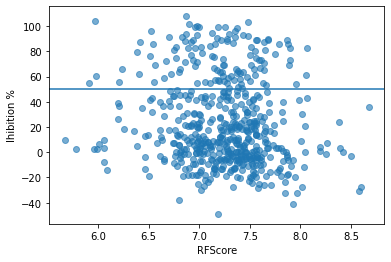

In [11]:
##rf score:
merged = rfscore.merge(small_df)

plt.scatter(merged['re_scores'], merged['inhib'],alpha=0.6)
plt.axhline(50)
plt.xlabel('RFScore')
plt.ylabel('Ihibition %')

Text(0, 0.5, 'Ihibition %')

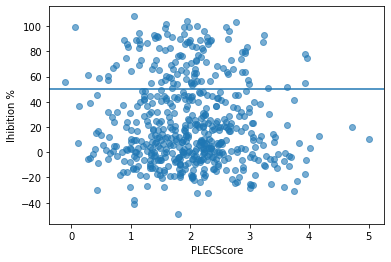

In [12]:
##PLEC score:
merged = plecscore.merge(small_df)

plt.scatter(merged['re_scores'], merged['inhib'],alpha=0.6)
plt.axhline(50)
plt.xlabel('PLECScore')
plt.ylabel('Ihibition %')

Text(0, 0.5, 'Ihibition %')

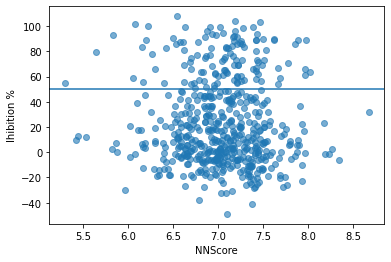

In [13]:
##NNscore (BINANA):
merged = nnscore.merge(small_df)

plt.scatter(merged['re_scores'], merged['inhib'],alpha=0.6)
plt.axhline(50)
plt.xlabel('NNScore')
plt.ylabel('Ihibition %')